In [1]:
%matplotlib inline

In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV

from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC

from sklearn.metrics import f1_score, make_scorer

# Should This Loan be Approved or Not? Draft

### Prepare data

#### Select relevant data

1. Read data.
1. Drop irrelevant variables (feature selection).
1. Rename remaining variables.
1. Format `approval_date` and sort out the new records (filtering).

In [3]:
PROJECT_DIRECTORY = Path(r"C:\Users\a1056968\Desktop\loan")
loan = pd.read_csv(PROJECT_DIRECTORY / "SBAnational.csv", low_memory=False)

In [4]:
irrelevant_variables = [
    'LoanNr_ChkDgt',
    'Name',
    'City',
    'Zip',
    'Bank',
    'BankState',
    'ApprovalFY',
    'ChgOffDate',
    'DisbursementDate',
    'BalanceGross',
    'ChgOffPrinGr',
]
loan = loan.drop(columns=irrelevant_variables)

In [5]:
new_column_names = [
    'state',
    'naics',
    'approval_date',
    'term',
    'employees_count',
    'business_lifetime',
    'created_jobs',
    'retained_jobs',
    'is_franchise',
    'location_type',
    'is_revolving_credit',
    'is_lowdoc',
    'disbursed_аmount',
    'mis_status',
    'gross_approved',
    'sba_approved',
]
loan.columns = new_column_names

In [6]:
INVALID_DATE_THRESHOLD = "2022-12-31"
loan.approval_date = pd.to_datetime(loan.approval_date, dayfirst=True)
loan.loc[loan.approval_date > INVALID_DATE_THRESHOLD, "approval_date"] -= pd.DateOffset(years=100)

START_DATE = "1990-01-01"
loan = loan[loan.approval_date >= START_DATE]

#### Handle data types and missing values

1. Print data types and count of NA values.
1. Drop the 4 pcs `NA` values for `state`. Verify there are no invalid state abbreviations.
1. 

In [7]:
print(f"Data Types\n\n{loan.dtypes}")

Data Types

state                          object
naics                           int64
approval_date          datetime64[ns]
term                            int64
employees_count                 int64
business_lifetime             float64
created_jobs                    int64
retained_jobs                   int64
is_franchise                    int64
location_type                   int64
is_revolving_credit            object
is_lowdoc                      object
disbursed_аmount               object
mis_status                     object
gross_approved                 object
sba_approved                   object
dtype: object


In [8]:
print(f"NA Values Count\n\n{loan.isna().sum()}")

NA Values Count

state                     4
naics                     0
approval_date             0
term                      0
employees_count           0
business_lifetime       136
created_jobs              0
retained_jobs             0
is_franchise              0
location_type             0
is_revolving_credit    4528
is_lowdoc              2582
disbursed_аmount          0
mis_status             1913
gross_approved            0
sba_approved              0
dtype: int64


In [9]:
loan = loan.dropna(subset=["state",])

STATES = pd.read_csv(PROJECT_DIRECTORY / "Reference/state_abbreviations.csv")
invalid_count = len(loan) - loan.state.isin(STATES.Postal).sum()
na_count = loan.state.isna().sum()
print(f"NA count: {na_count}\nInvalid count: {invalid_count}")

NA count: 0
Invalid count: 0


In [10]:
industry_sector = loan.naics // 10000
loan['industry_sector'] = industry_sector

In [11]:
loan.industry_sector.value_counts(dropna=False)

0     179601
44     83425
81     71370
54     67615
72     67478
23     65827
62     54575
42     47794
45     41830
33     37396
56     32575
48     20277
32     17535
71     14494
53     13487
31     11563
51     11330
52      9493
11      8752
61      6413
49      2214
21      1808
22       654
55       255
92       227
Name: industry_sector, dtype: int64

In [12]:
loan.naics[loan.naics == 0].count()

179601

In [13]:
loan = loan.drop(columns="naics")

In [14]:
def currency_to_float(series):
    result = series.replace(
        to_replace='[\$,]',
        value='',
        regex=True,
    )
    result = result.astype("float64")
    
    return result

In [15]:
loan.head()

,state,approval_date,term,employees_count,business_lifetime,created_jobs,retained_jobs,is_franchise,location_type,is_revolving_credit,is_lowdoc,disbursed_аmount,mis_status,gross_approved,sba_approved,industry_sector
0,IN,1997-02-28,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",P I F,"$60,000.00","$48,000.00",45
1,IN,1997-02-28,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",P I F,"$40,000.00","$32,000.00",72
2,IN,1997-02-28,180,7,1.0,0,0,1,0,N,N,"$287,000.00",P I F,"$287,000.00","$215,250.00",62
3,OK,1997-02-28,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",P I F,"$35,000.00","$28,000.00",0
4,FL,1997-02-28,240,14,1.0,7,7,1,0,N,N,"$229,000.00",P I F,"$229,000.00","$229,000.00",0


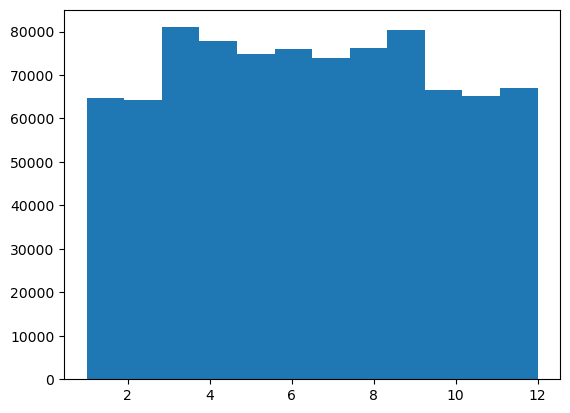

In [16]:
plt.hist(loan.approval_date.dt.month, bins=12)
plt.show()

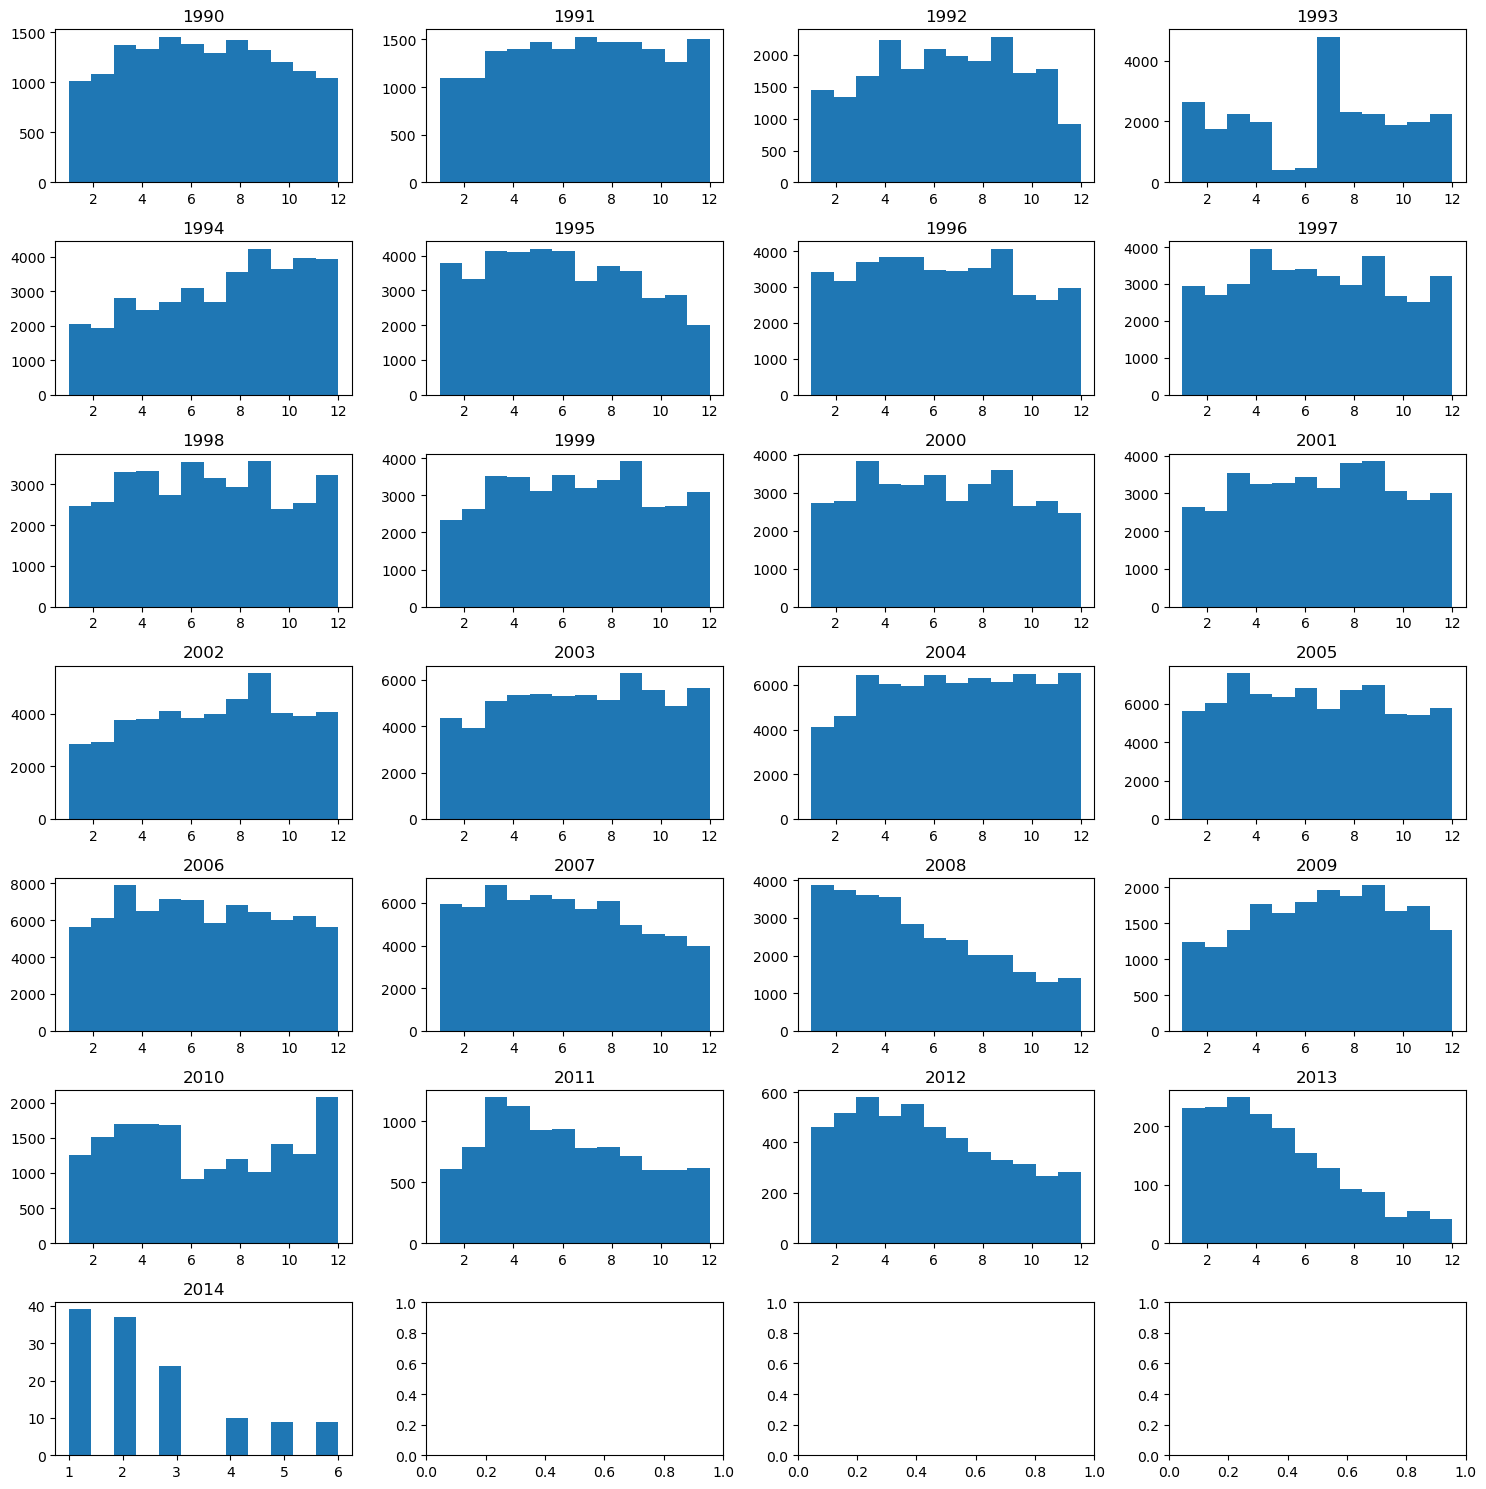

In [17]:
n_plots = loan.approval_date.dt.year.nunique()
fig, axs = plt.subplots(n_plots // 4 + 1, 4, figsize=(15, 15))

for ax, (name, grouped_data) in zip(axs.flat, loan.groupby(loan.approval_date.dt.year)):
    ax.hist(grouped_data.approval_date.dt.month, bins=12)
    ax.set_title(name)

plt.tight_layout()
plt.show()

loan

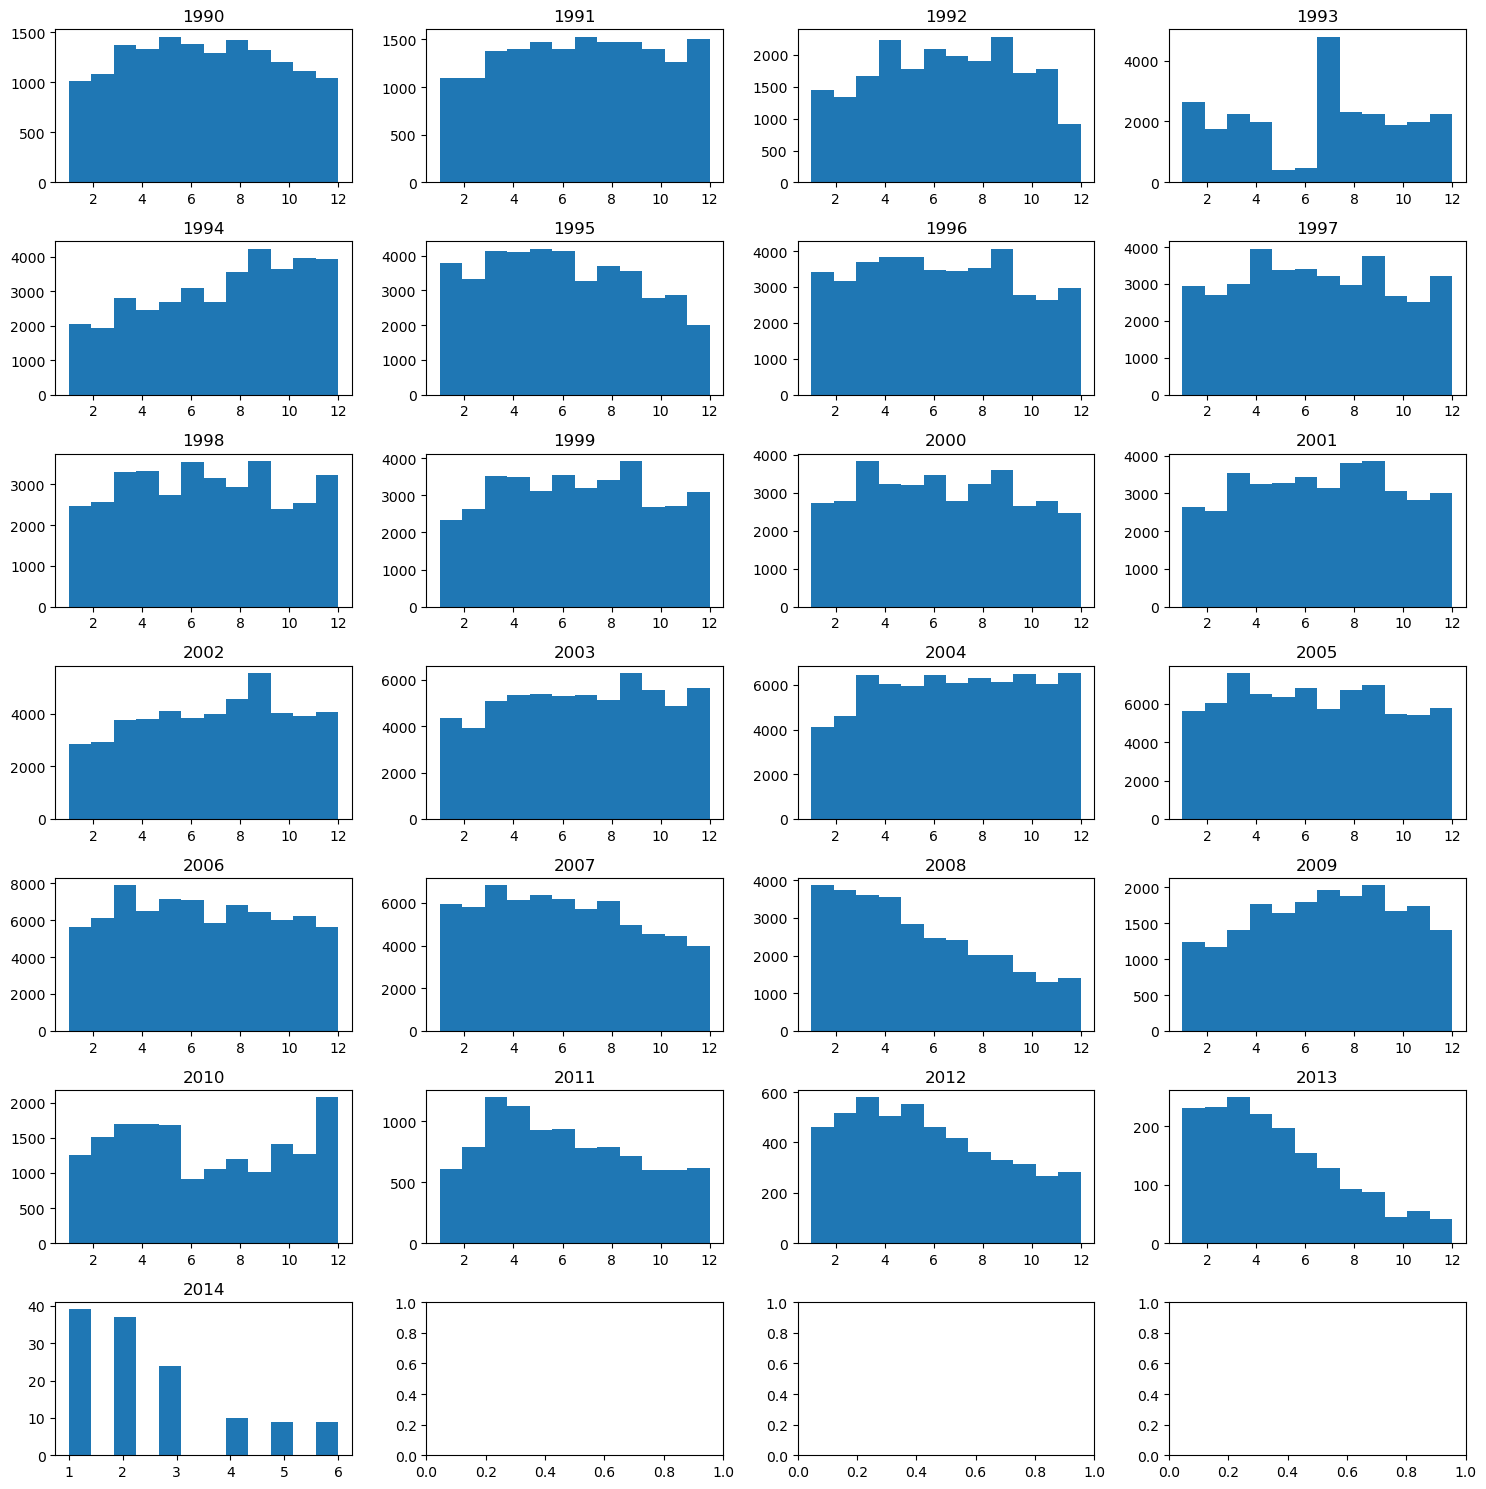

In [18]:
n_plots = loan.approval_date.dt.year.nunique()
fig, axs = plt.subplots(n_plots // 4 + 1, 4, figsize=(15, 15))

for ax, (name, grouped_data) in zip(axs.flat, loan.groupby(loan.approval_date.dt.year)):
    ax.hist(grouped_data.approval_date.dt.month, bins=12)
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [19]:
loan[["disbursed_аmount", "gross_approved", "sba_approved"]] = loan[["disbursed_аmount", "gross_approved", "sba_approved"]].apply(currency_to_float)

In [20]:
loan[["disbursed_аmount", "gross_approved", "sba_approved"]].isna().sum()

disbursed_аmount    0
gross_approved      0
sba_approved        0
dtype: int64

In [21]:
amount_guaranteed_by_sba = currency_to_float(loan.sba_approved)
total_amount = currency_to_float(loan.gross_approved)

loan["sba_proportion"] = amount_guaranteed_by_sba / total_amount

In [22]:
MAX_TERM_FOR_LOANS_NOT_BACKED_UP_BY_REALESTATE = 240
loan["is_backed_by_realestate"] = False
loan.loc[loan.term >= MAX_TERM_FOR_LOANS_NOT_BACKED_UP_BY_REALESTATE, "is_backed_by_realestate"] = True

In [23]:
loan.business_lifetime.value_counts(dropna=False)

1.0    621913
2.0    244969
0.0       970
NaN       136
Name: business_lifetime, dtype: int64

In [24]:
loan.business_lifetime = loan.business_lifetime.fillna(0)

In [25]:
loan.business_lifetime = loan.business_lifetime.astype("int64")

In [26]:
loan.created_jobs.value_counts(dropna=False)

0       602149
1        63154
2        57766
3        28713
4        20366
         ...  
223          1
129          1
252          1
3100         1
860          1
Name: created_jobs, Length: 239, dtype: int64

In [27]:
loan.retained_jobs.value_counts(dropna=False)

0       412344
1        88705
2        76782
3        49892
4        39574
         ...  
217          1
221          1
342          1
7250         1
198          1
Name: retained_jobs, Length: 351, dtype: int64

In [28]:
loan.is_franchise.value_counts(dropna=False)

1        633561
0        184170
78760      3345
68020      1921
50564      1018
          ...  
73200         1
32175         1
71680         1
90500         1
15930         1
Name: is_franchise, Length: 2661, dtype: int64

In [29]:
loan.loc[~loan.is_franchise.isin([1, 0]), "is_franchise"] = 2

In [30]:
loan.is_franchise.value_counts(dropna=False)

1    633561
0    184170
2     50257
Name: is_franchise, dtype: int64

0 = is NOT francise
1 = IS francise
2 = other / unknown

In [31]:
loan = loan.drop(columns="is_franchise")

In [32]:
loan.location_type.value_counts(dropna=False)

1    470654
0    291991
2    105343
Name: location_type, dtype: int64

0: "undefined"
1: "urban"
2: "rural"

In [33]:
loan = loan.drop(columns="location_type")

In [34]:
loan.is_revolving_credit.value_counts(dropna=False)

N      389141
0      257602
Y      201368
T       15284
NaN      4528
1          23
R          14
`          11
2           6
C           2
5           1
-           1
4           1
.           1
3           1
A           1
7           1
,           1
Q           1
Name: is_revolving_credit, dtype: int64

In [35]:
loan.loc[~loan.is_revolving_credit.isin(["N", "Y"]), "is_revolving_credit"] = 0

In [36]:
loan.is_revolving_credit.value_counts(dropna=False)

N    389141
0    277479
Y    201368
Name: is_revolving_credit, dtype: int64

yes, no, 0 = unknown

In [37]:
loan = loan.drop(columns="is_revolving_credit")

In [38]:
loan.is_lowdoc.value_counts(dropna=False)

N      751648
Y      110333
NaN      2582
0        1491
C         758
S         603
A         497
R          75
1           1
Name: is_lowdoc, dtype: int64

In [39]:
loan.loc[~loan.is_lowdoc.isin(["N", "Y"]), "is_lowdoc"] = 0

In [40]:
loan.is_lowdoc.value_counts(dropna=False)

N    751648
Y    110333
0      6007
Name: is_lowdoc, dtype: int64

In [41]:
loan = loan.drop(columns="is_lowdoc")

In [42]:
loan.mis_status.value_counts(dropna=False)

P I F     716487
CHGOFF    149588
NaN         1913
Name: mis_status, dtype: int64

In [43]:
loan.shape, loan.dropna(subset=["mis_status"]).shape

((867988, 14), (866075, 14))

In [44]:
loan = loan.dropna(subset=["mis_status"])

In [45]:
loan.mis_status.value_counts(dropna=False)

P I F     716487
CHGOFF    149588
Name: mis_status, dtype: int64

In [46]:
loan.mis_status = loan.mis_status.replace({
    "P I F": False,
    "CHGOFF": True,
})

loan = loan.rename(columns = {
    "mis_status": "is_defaulted",
})

In [47]:
loan.is_defaulted.value_counts(dropna=False)

False    716487
True     149588
Name: is_defaulted, dtype: int64

In [48]:
RECESSION_START = "2007-12"
RECESSION_END = "2009-06"
loan["is_during_recession"] = (RECESSION_START <= loan.approval_date) & (loan.approval_date <= RECESSION_END)

In [49]:
loan = loan.drop(columns=["sba_approved", "gross_approved"])

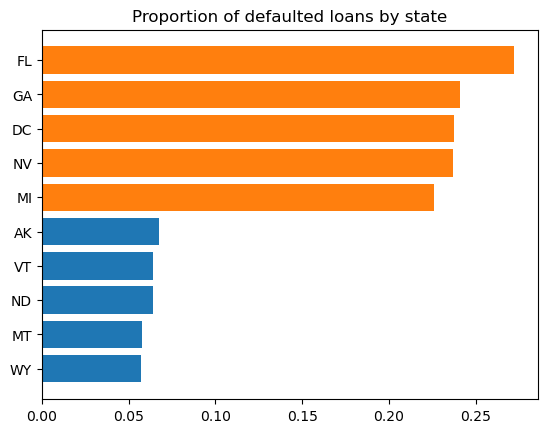

In [50]:
proportion_of_defaults = loan.groupby("state").is_defaulted.sum() / loan.groupby("state").is_defaulted.count()

x = proportion_of_defaults.nsmallest(5)
plt.barh(x.index, x)

x = proportion_of_defaults.nlargest(5).sort_values()
plt.barh(x.index, x)

plt.title("Proportion of defaulted loans by state")
plt.show()

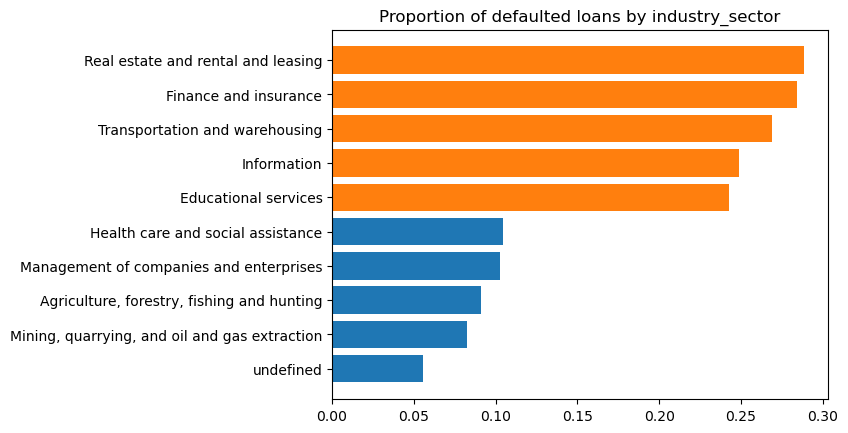

In [51]:
INDUSTRY_SECTORS = {
    11: "Agriculture, forestry, fishing and hunting",
    21: "Mining, quarrying, and oil and gas extraction",
    22: "Utilities",
    23: "Construction",
    31: "Manufacturing",
    32: "Manufacturing",
    33: "Manufacturing",
    42: "Wholesale trade",
    44: "Retail trade",
    45: "Retail trade",
    48: "Transportation and warehousing",
    49: "Transportation and warehousing",
    51: "Information",
    52: "Finance and insurance",
    53: "Real estate and rental and leasing",
    54: "Professional, scientific, and technical services",
    55: "Management of companies and enterprises",
    56: "Administrative and support and waste management and remediation services",
    61: "Educational services",
    62: "Health care and social assistance",
    71: "Arts, entertainment, and recreation",
    72: "Accommodation and food services",
    81: "Other services (except public administration)",
    92: "Public administration",
}

proportion_of_defaults = loan.groupby("industry_sector").is_defaulted.sum() / loan.groupby("industry_sector").is_defaulted.count()
proportion_of_defaults.index = [INDUSTRY_SECTORS.get(i, "undefined") for i in proportion_of_defaults.index]

y = proportion_of_defaults.nsmallest(5)
plt.barh(y.index, y.values)

y = proportion_of_defaults.nlargest(5).sort_values()
plt.barh(y.index, y.values)

plt.title("Proportion of defaulted loans by industry_sector")
plt.show()

In [52]:
def plot_proportion(series):
    plt.pie(
        x=series.value_counts(),
        labels=series.value_counts().index,
        autopct="%.1f",
    )
    plt.show()

In [53]:
loan.head()

,state,approval_date,term,employees_count,business_lifetime,created_jobs,retained_jobs,disbursed_аmount,is_defaulted,industry_sector,sba_proportion,is_backed_by_realestate,is_during_recession
0,IN,1997-02-28,84,4,2,0,0,60000.0,False,45,0.80,False,False
1,IN,1997-02-28,60,2,2,0,0,40000.0,False,72,0.80,False,False
2,IN,1997-02-28,180,7,1,0,0,287000.0,False,62,0.75,False,False
3,OK,1997-02-28,60,2,1,0,0,35000.0,False,0,0.80,False,False
4,FL,1997-02-28,240,14,1,7,7,229000.0,False,0,1.00,True,False


In [54]:
loan["approval_date_month"] = loan.approval_date.dt.month

In [55]:
loan = loan.drop(columns=["approval_date"])

In [56]:
list(loan.columns)

['state',
 'term',
 'employees_count',
 'business_lifetime',
 'created_jobs',
 'retained_jobs',
 'disbursed_аmount',
 'is_defaulted',
 'industry_sector',
 'sba_proportion',
 'is_backed_by_realestate',
 'is_during_recession',
 'approval_date_month']

In [57]:
loan = loan[[
    'state',
    'term',
    'employees_count',
    'business_lifetime',
    'created_jobs',
    'retained_jobs',
    'disbursed_аmount',
    'industry_sector',
    'sba_proportion',
    'is_backed_by_realestate',
    'is_during_recession',
    'approval_date_month',
    'is_defaulted',
]]

In [58]:
loan.dtypes

state                       object
term                         int64
employees_count              int64
business_lifetime            int64
created_jobs                 int64
retained_jobs                int64
disbursed_аmount           float64
industry_sector              int64
sba_proportion             float64
is_backed_by_realestate       bool
is_during_recession           bool
approval_date_month          int64
is_defaulted                  bool
dtype: object

In [59]:
loan.isna().sum()

state                      0
term                       0
employees_count            0
business_lifetime          0
created_jobs               0
retained_jobs              0
disbursed_аmount           0
industry_sector            0
sba_proportion             0
is_backed_by_realestate    0
is_during_recession        0
approval_date_month        0
is_defaulted               0
dtype: int64

### Model

In [60]:
loan_attributes = loan.drop(columns="is_defaulted")
is_defaulted = loan.is_defaulted

In [61]:
categorical_features = [
    'state',
    'business_lifetime',
    'industry_sector',
    'approval_date_month',
]
loan_attributes[categorical_features] = loan_attributes[categorical_features].astype('category')

In [62]:
boolean_features = [
    'is_backed_by_realestate',
    'is_during_recession',
]
loan_attributes[boolean_features] = loan_attributes[boolean_features].astype('bool')

In [63]:
loan_attributes.dtypes

state                      category
term                          int64
employees_count               int64
business_lifetime          category
created_jobs                  int64
retained_jobs                 int64
disbursed_аmount            float64
industry_sector            category
sba_proportion              float64
is_backed_by_realestate        bool
is_during_recession            bool
approval_date_month        category
dtype: object

In [64]:
loan_attributes.select_dtypes(["category", "bool"]).head()

,state,business_lifetime,industry_sector,is_backed_by_realestate,is_during_recession,approval_date_month
0,IN,2,45,False,False,2
1,IN,2,72,False,False,2
2,IN,1,62,False,False,2
3,OK,1,0,False,False,2
4,FL,1,0,True,False,2


In [65]:
for c in loan_attributes.columns:
    if loan_attributes[c].dtype in ["category", "bool"]:
        print(c, "\n", loan_attributes[c].value_counts())

state 
 CA    126321
TX     67900
NY     55696
FL     40655
PA     34234
OH     31009
IL     28631
MA     24356
MN     23769
NJ     23596
WA     22354
GA     21218
CO     20100
WI     20019
MI     19946
MO     18992
UT     18195
AZ     17282
NC     13749
IN     13587
MD     12997
VA     12949
CT     11986
NH     11727
IA     11062
OR     10709
KS     10498
OK      9556
LA      9265
ID      9129
TN      8978
RI      8775
MT      8251
AL      7752
NV      7687
MS      7462
KY      7241
AR      6163
NE      6064
NM      5775
ME      5711
SC      5409
ND      4986
VT      4929
SD      4109
HI      3492
WV      3155
WY      2750
AK      2157
DE      2152
DC      1590
Name: state, dtype: int64
business_lifetime 
 1    620537
2    244434
0      1104
Name: business_lifetime, dtype: int64
industry_sector 
 0     179404
44     83255
81     71147
72     67389
54     67367
23     65673
62     54473
42     47724
45     41724
33     37318
56     32419
48     20165
32     17504
71     14470
53     13

In [66]:
encoder = OneHotEncoder()
encoder.fit_transform(loan_attributes.select_dtypes(["category", "bool"]))

<866075x95 sparse matrix of type '<class 'numpy.float64'>'
	with 5196450 stored elements in Compressed Sparse Row format>

In [67]:
scaler = MinMaxScaler()

In [68]:
column_transformer = ColumnTransformer([
    ("categorical", encoder, loan_attributes.select_dtypes(["category", "bool"]).columns),
    ("numeric", scaler, loan_attributes.select_dtypes(["int64", "float64"]).columns),
])

In [75]:
loan_attributes_transformed = column_transformer.fit_transform(loan_attributes)

In [70]:
loan_attributes.dtypes

state                      category
term                          int64
employees_count               int64
business_lifetime          category
created_jobs                  int64
retained_jobs                 int64
disbursed_аmount            float64
industry_sector            category
sba_proportion              float64
is_backed_by_realestate        bool
is_during_recession            bool
approval_date_month        category
dtype: object

In [77]:
loan_attributes_transformed.shape

(866075, 101)

In [ ]:
is_defaulted.value_counts(dropna=False)

False    716487
True     149588
Name: is_defaulted, dtype: int64

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    loan_attributes_transformed, is_defaulted, stratify=is_defaulted, test_size=0.1)

In [86]:
logreg = LogisticRegression(C=10)

In [87]:
logreg.fit(X_train, y_train)

C:\Users\a1056968\Anaconda3\envs\machine_learning\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=10)

In [88]:
y_true = y_train
y_pred = logreg.predict(X_train)
f1_score(y_true=y_true, y_pred=y_pred)

0.4142708306863518

In [89]:
y_true = y_test
y_pred = logreg.predict(X_test)
f1_score(y_true=y_true, y_pred=y_pred)

0.4155939012142792

In [90]:
tree= DecisionTreeClassifier()

In [91]:
tree.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
y_true = y_train
y_pred = logreg.predict(X_train)
f1_score(y_true=y_true, y_pred=y_pred)